In [37]:
import tensorflow as tf
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
import soundfile as sf
from typing import Tuple, Optional, List
from tensorflow.keras.callbacks import EarlyStopping


In [38]:
def load_audio_file(file_path: str, sr: int = 16000) -> np.ndarray:
    """
    Load an audio file with a specified sample rate.
    
    Args:
        file_path (str): Path to the audio file.
        sr (int): Sample rate for loading the audio.
    
    Returns:
        np.ndarray: Loaded audio signal.
    """
    audio, _ = librosa.load(file_path, sr=sr)
    return audio

def audio_to_spectrogram(audio: np.ndarray, n_fft: int = 1024, hop_length: int = 512) -> np.ndarray:
    """
    Convert audio signal to a spectrogram.
    """
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    return np.abs(stft)

def spectrogram_to_audio(spectrogram: np.ndarray, hop_length: int = 512) -> np.ndarray:
    """
    Convert a spectrogram back to an audio signal.
    
    Args:
        spectrogram (np.ndarray): Spectrogram.
        hop_length (int): Number of samples between successive frames.
    
    Returns:
        np.ndarray: Reconstructed audio signal.
    """
    stft_reconstructed = librosa.istft(spectrogram, hop_length=hop_length)
    return stft_reconstructed

def load_audio_files_from_directory(directory: str, extensions: List[str], sr: int = 16000) -> List[np.ndarray]:
    """
    Load all audio files with specified extensions from a directory and its subdirectories.

    Args:
        directory (str): Root directory to search for audio files.
        extensions (List[str]): List of acceptable file extensions.
        sr (int): Sample rate for loading the audio.

    Returns:
        List[np.ndarray]: List of loaded audio signals.
    """
    audio_files = []
    for root, _, files in os.walk(directory):
        # Filter files by specified extensions
        for file in files:
            if any(file.lower().endswith(ext) for ext in extensions):
                file_path = os.path.join(root, file)
                # Load the audio file
                audio, _ = librosa.load(file_path, sr=sr)
                audio_files.append(audio)
    return audio_files



In [39]:
def load_data(noise_dir: str, clean_dir: str, noisy_dir: str, limit: Optional[int] = None, fixed_length: int = 300) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Load noise, clean, and noisy audio data from specified directories and convert them to spectrograms.

    Args:
        noise_dir (str): Directory for noise recordings.
        clean_dir (str): Directory for clean recordings.
        noisy_dir (str): Directory for noisy recordings.
        limit (Optional[int]): Limit the number of files to load.
        fixed_length (int): Fixed time dimension length for spectrograms.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Arrays of noise, clean, and noisy spectrograms.
    """
    # Load audio files from directories and subdirectories
    noise_files = load_audio_files_from_directory(noise_dir, ['.wav'])[:limit]
    clean_files = load_audio_files_from_directory(clean_dir, ['.flac'])[:limit]
    noisy_files = load_audio_files_from_directory(noisy_dir, ['.mp3'])[:limit]

    def pad_or_truncate(spectrogram, target_length):
        if spectrogram.shape[1] > target_length:
            return spectrogram[:, :target_length]
        return np.pad(spectrogram, ((0, 0), (0, target_length - spectrogram.shape[1])), mode='constant')

    # Convert to spectrograms and ensure a consistent length
    noise_specs = [pad_or_truncate(audio_to_spectrogram(a), fixed_length) for a in noise_files]
    clean_specs = [pad_or_truncate(audio_to_spectrogram(a), fixed_length) for a in clean_files]
    noisy_specs = [pad_or_truncate(audio_to_spectrogram(a), fixed_length) for a in noisy_files]

    return np.array(noise_specs), np.array(clean_specs), np.array(noisy_specs)


In [ ]:
def build_denoising_cnn(input_shape: Tuple[int, int, int]) -> tf.keras.Model:
    """
    Define a CNN model for audio noise reduction with precise shape matching adjustments.
    
    Args:
        input_shape (Tuple[int, int, int]): Shape of the input spectrogram (height, width, channels).
    
    Returns:
        tf.keras.Model: Compiled denoising CNN model.
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        # Encoder
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # Output: (513, 300, 32)
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # Output: (513, 300, 32)
        layers.MaxPooling2D((2, 2), padding='same'),                   # Output: (257, 150, 32)
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Output: (257, 150, 64)
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Output: (257, 150, 64)
        layers.MaxPooling2D((2, 2), padding='same'),                   # Output: (129, 75, 64)
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'), # Output: (129, 75, 128)
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'), # Output: (129, 75, 128)
        layers.MaxPooling2D((2, 2), padding='same'),                   # Output: (65, 38, 128)
        
        # Decoder
        layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'), # Output: (65, 38, 128)
        layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'), # Output: (65, 38, 128)
        layers.UpSampling2D((2, 2)),                                            # Output: (130, 76, 128)
        
        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),  # Output: (130, 76, 64)
        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),  # Output: (130, 76, 64)
        layers.UpSampling2D((2, 2)),                                            # Output: (260, 152, 64)
        
        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),  # Output: (260, 152, 32)
        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),  # Output: (260, 152, 32)
        layers.UpSampling2D((2, 2)),                                            # Output: (520, 304, 32)
        
        # Output layer to match input dimensions exactly
        layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'),         # Output: (520, 304, 1)
        layers.Cropping2D(((3, 4), (2, 2)))                                     # Final Output: (513, 300, 1)
    ])
    
    # Confirm model output shape
    print("Expected input shape:", input_shape)
    print("Model output shape:", model.output_shape)
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [41]:
def train_with_kfold(train_noisy, train_clean, input_shape: Tuple[int, int, int], k: int = 1, epochs: int = 20, batch_size: int = 8):
    """
    Train the model using k-fold cross-validation with early stopping based on validation loss.
    
    Args:
        train_noisy (np.ndarray): Noisy training data.
        train_clean (np.ndarray): Clean target training data.
        input_shape (Tuple[int, int, int]): Input shape for the model.
        k (int): Number of folds for cross-validation.
        epochs (int): Number of epochs for each training fold.
        batch_size (int): Batch size for each training fold.
    
    Returns:
        List of training history objects for each fold.
    """
    kf = KFold(n_splits=k)
    histories = []
    
    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',    # Monitor validation loss
        min_delta=0.001,       # Minimum change to qualify as improvement
        patience=10,           # Number of epochs to wait for improvement
        restore_best_weights=True  # Restore model weights from the best epoch
    )
    
    for fold, (train_index, val_index) in enumerate(kf.split(train_noisy)):
        print(f"Training fold {fold + 1}/{k}")
        
        # Split data for this fold
        X_train, X_val = train_noisy[train_index], train_noisy[val_index]
        y_train, y_val = train_clean[train_index], train_clean[val_index]
        
        # Build and compile the model
        model = build_denoising_cnn(input_shape)
        
        # Train the model with EarlyStopping
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,            # Using specified epochs
            batch_size=batch_size,    # Using specified batch size
            callbacks=[early_stopping]  # Add EarlyStopping to callbacks
        )
        
        # Append the history for analysis
        histories.append(history)
        
    return histories


In [42]:
def plot_training_history(histories):
    """
    Plot the training history for MSE, MAE, and MAPE metrics.
    """
    sns.set(style="whitegrid")
    for metric in ['loss', 'mae', 'mape']:
        plt.figure(figsize=(10, 6))
        for history in histories:
            plt.plot(history.history[metric], label='Train ' + metric)
            plt.plot(history.history['val_' + metric], label='Validation ' + metric)
        plt.title(f'Training and Validation {metric.upper()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.upper())
        plt.legend()
        plt.show()

    # Combined plot for all metrics
    plt.figure(figsize=(12, 8))
    for metric in ['loss', 'mae', 'mape']:
        for history in histories:
            plt.plot(history.history[metric], label='Train ' + metric)
            plt.plot(history.history['val_' + metric], label='Validation ' + metric)
    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.show()


In [55]:
def plot_spectrogram_comparisons(model, noisy_file_paths: List[str], clean_file_paths: List[str], column_names: List[str]):
    """
    Plot spectrogram comparisons for noisy, predicted, and clean spectrograms.

    Args:
        model (tf.keras.Model): The denoising model.
        noisy_file_paths (List[str]): List of paths to the noisy audio files.
        clean_file_paths (List[str]): List of paths to the corresponding clean audio files.
        column_names (List[str]): Column titles, typically representing speaker or test case names.
    """
    fig, axes = plt.subplots(3, len(noisy_file_paths), figsize=(15, 8))
    fig.suptitle('Spectrogram Comparisons')
    
    for idx, (noisy_path, clean_path) in enumerate(zip(noisy_file_paths, clean_file_paths)):
        # Load audio data
        noisy_audio = load_audio_file(noisy_path)
        clean_audio = load_audio_file(clean_path)
        
        # Convert audio to spectrograms
        noisy_spectrogram = audio_to_spectrogram(noisy_audio)
        clean_spectrogram = audio_to_spectrogram(clean_audio)
        
        # Predict denoised spectrogram from noisy input
        noisy_input = noisy_spectrogram[np.newaxis, ..., np.newaxis]  # Add batch and channel dimension
        predicted_spectrogram = model.predict(noisy_input)[0, ..., 0]  # Remove batch and channel dimensions
        
        # Plot spectrograms
        sns.heatmap(noisy_spectrogram, ax=axes[0, idx], cbar=False).set_title(column_names[idx])
        sns.heatmap(predicted_spectrogram, ax=axes[1, idx], cbar=False)
        sns.heatmap(clean_spectrogram, ax=axes[2, idx], cbar=False)
    
    # Set row labels
    axes[0, 0].set_ylabel("Noisy")
    axes[1, 0].set_ylabel("Predicted")
    axes[2, 0].set_ylabel("Clean")
    
    plt.show()


In [44]:
# Set paths for training and validation data
train_noise_path = '../../../data/audios/english/train/noise'
train_clean_path = '../../../data/audios/english/train/clean'
train_noisy_path = '../../../data/audios/english/train/blended'
train_clean_path = '../../../data/audios/english/train/clean_trim'
train_noisy_path = '../../../data/audios/english/train/blended_trim'

# val_noise_path = '../../../data/audios/english/validation/noise'
# val_clean_path = '../../../data/audios/english/validation/clean'
# val_noisy_path = '../../../data/audios/english/validation/blended'
# val_clean_path = '../../../data/audios/english/validation/clean_trim'
# val_noisy_path = '../../../data/audios/english/validation/blended_trim'

# Load training and validation data (limit as needed)
train_noise, train_clean, train_noisy = load_data(train_noise_path, train_clean_path, train_noisy_path, limit=100, fixed_length=300)
# val_noise, val_clean, val_noisy = load_data(val_noise_path, val_clean_path, val_noisy_path, limit=100, fixed_length=300)

# Add channel dimension for CNN input
train_noisy = train_noisy[..., np.newaxis]
train_clean = train_clean[..., np.newaxis]
# val_noisy = val_noisy[..., np.newaxis]
# val_clean = val_clean[..., np.newaxis]

# Debugging statements to inspect shapes
print("Training data shapes:")
print("train_noisy:", train_noisy.shape)
print("train_clean:", train_clean.shape)
print("Validation data shapes:")
# print("val_noisy:", val_noisy.shape)
# print("val_clean:", val_clean.shape)

# Build and train model
input_shape = train_noisy.shape[1:]  # Use shape of one sample
model = build_denoising_cnn(input_shape)
# history = model.fit(train_noisy, train_clean, validation_data=(val_noisy, val_clean), epochs=20, batch_size=8)
histories = train_with_kfold(train_noisy, train_clean, input_shape=input_shape, k=3, epochs=10, batch_size=32)


Training data shapes:
train_noisy: (100, 513, 300, 1)
train_clean: (100, 513, 300, 1)
Validation data shapes:
Expected input shape: (513, 300, 1)
Model output shape: (None, 513, 300, 1)
Training fold 1/3
Expected input shape: (513, 300, 1)
Model output shape: (None, 513, 300, 1)
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 114s 29s/step - loss: 1.8403 - mae: 0.5739 - mape: 3196881.0000 - val_loss: 1.3520 - val_mae: 0.6077 - val_mape: 21824744.0000
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 20s/step - loss: 1.8152 - mae: 0.6036 - mape: 5354833.0000 - val_loss: 1.3428 - val_mae: 0.5303 - val_mape: 21525250.0000
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 22s/step - loss: 1.8320 - mae: 0.5575 - mape: 5266648.0000 - val_loss: 1.3065 - val_mae: 0.5541 - val_mape: 20765054.0000
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 80s 22s/step - loss: 1.7661 - mae: 0.5838 - mape: 5086491.0000 - val_loss: 1.2606 - val_mae: 0.5028 - val_mape: 17648068.0000
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 87s 26s/step - loss: 1.7704 - mae: 

In [45]:
# Save the model to both .h5 and .keras formats
model.save('ML-DAN_v3.1.h5')
model.save('ML-DAN_v3.1.keras')


In [57]:
def denoise_audio(model: tf.keras.Model, noisy_audio_path: str, output_path: str) -> None:
    """
    Apply noise reduction on a noisy audio file and save the cleaned audio.
    
    Args:
        model (tf.keras.Model): Trained noise reduction model.
        noisy_audio_path (str): Path to the noisy audio file.
        output_path (str): Path where the denoised audio will be saved.
    """
    # Load and convert noisy audio to spectrogram
    noisy_audio = load_audio_file(noisy_audio_path)
    noisy_spectrogram = audio_to_spectrogram(noisy_audio)
    
    # Add batch and channel dimension for model prediction
    noisy_spectrogram = noisy_spectrogram[np.newaxis, ..., np.newaxis]
    
    # Predict clean spectrogram
    predicted_clean_spectrogram = model.predict(noisy_spectrogram)[0, ..., 0]
    
    # Convert predicted spectrogram back to audio
    cleaned_audio = spectrogram_to_audio(predicted_clean_spectrogram)
    
    # Save the cleaned audio
    sf.write(output_path, cleaned_audio, 16000)

# Example usage of the denoising function
denoise_audio(model, '../../../data/audios/english/train/blended/19-198-0002.mp3', 'testV3.wav')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


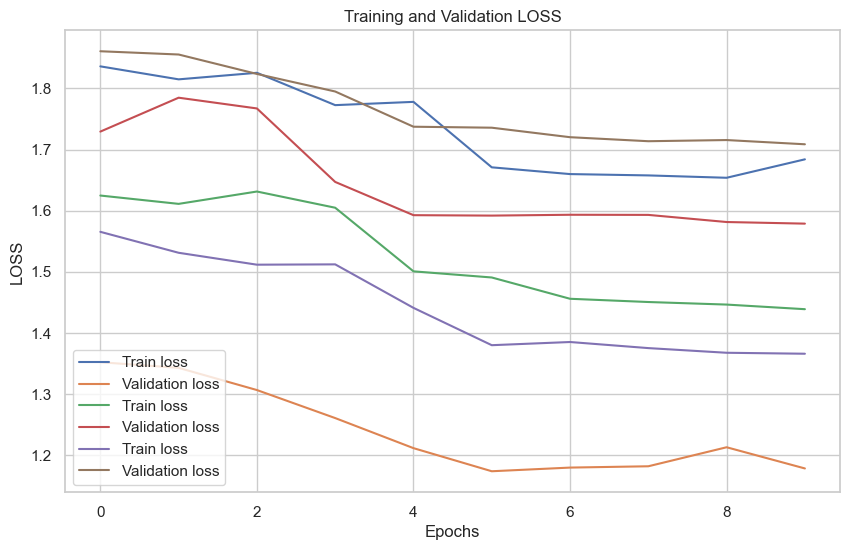

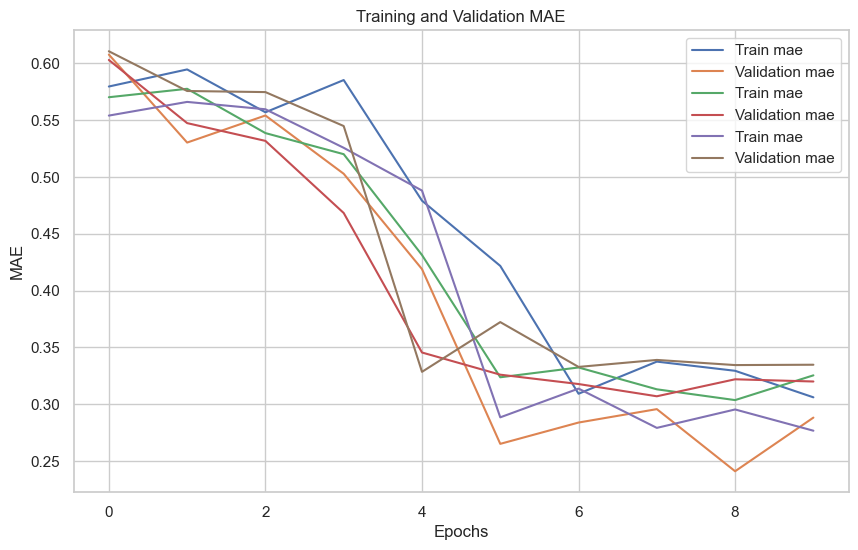

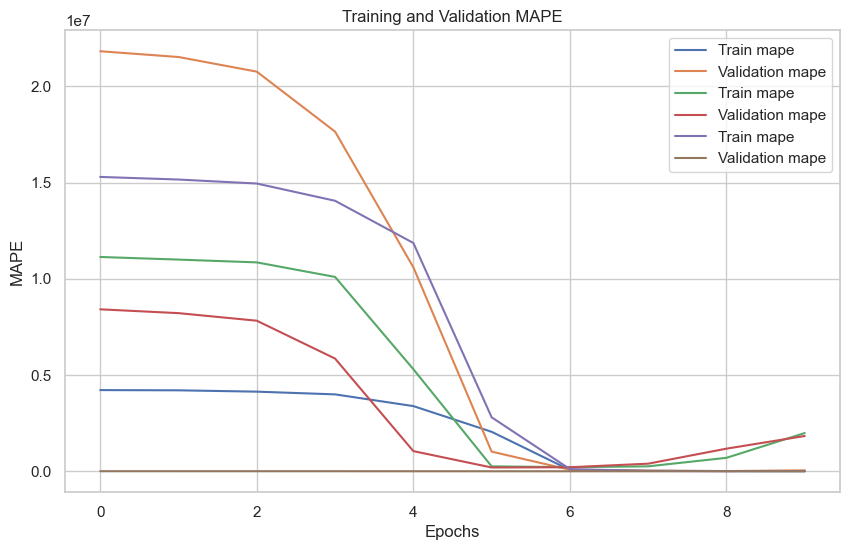

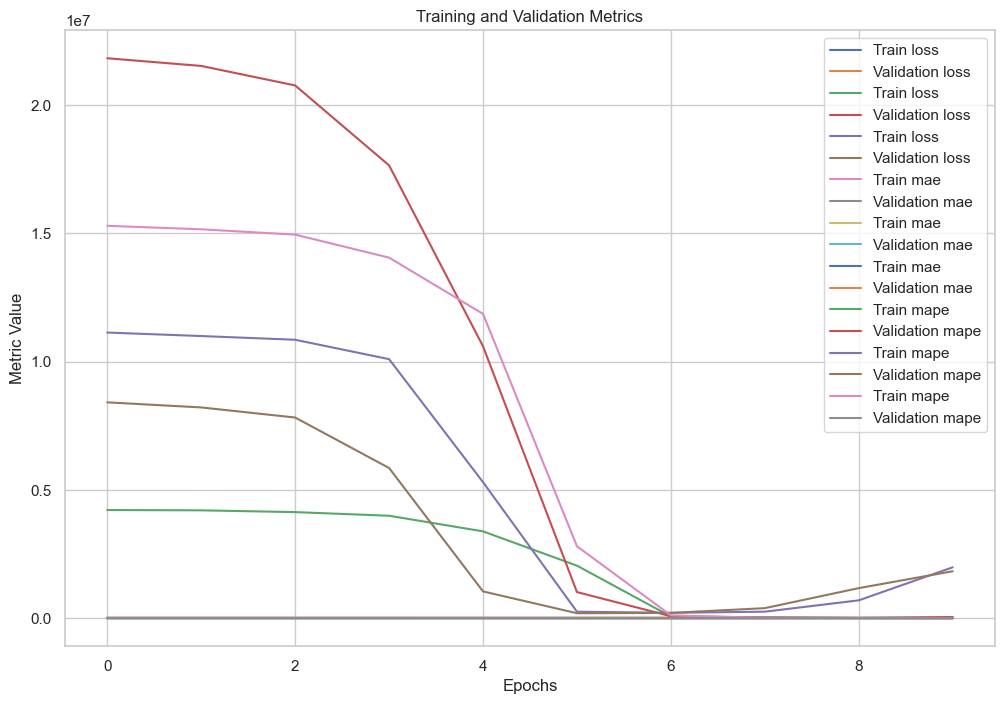

In [47]:
# Plot training metrics
plot_training_history(histories)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


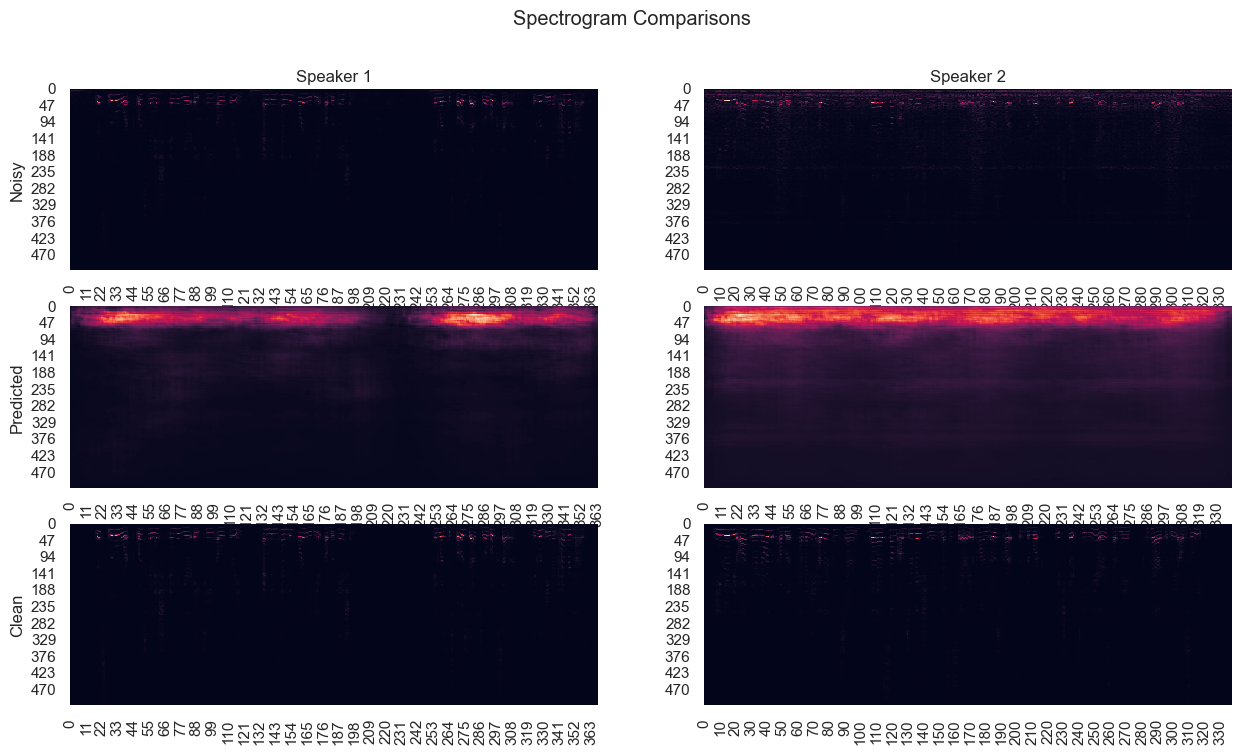

In [56]:
noisy_file_paths = [
    "../../../data/audios/english/train/blended/19-198-0001.mp3",
    "../../../data/audios/english/train/blended/19-198-0002.mp3"
]
clean_file_paths = [
    "../../../data/audios/english/train/clean/19/198/19-198-0001.flac",
    "../../../data/audios/english/train/clean/19/198/19-198-0002.flac"
]
column_names = ["Speaker 1", "Speaker 2"]

plot_spectrogram_comparisons(model, noisy_file_paths, clean_file_paths, column_names)


Example 1:


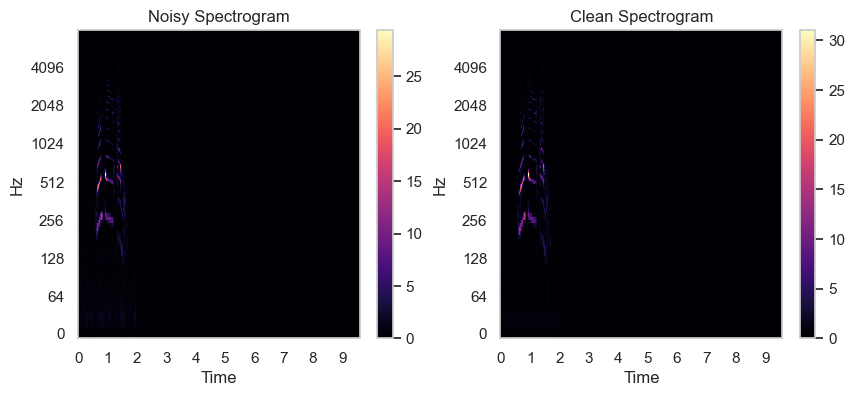

Example 2:


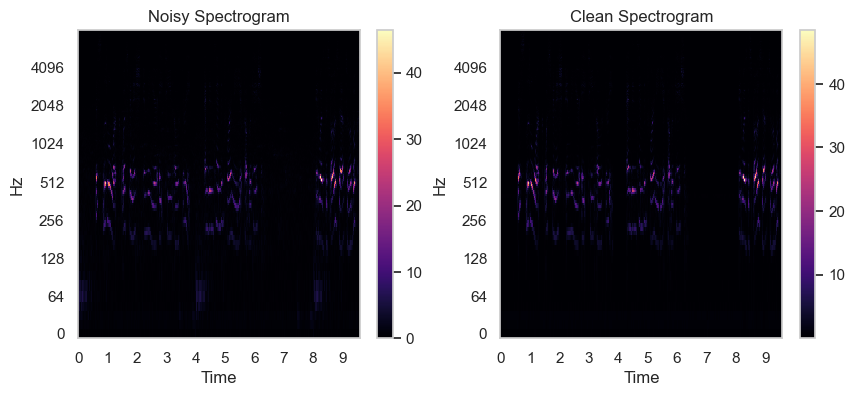

Example 3:


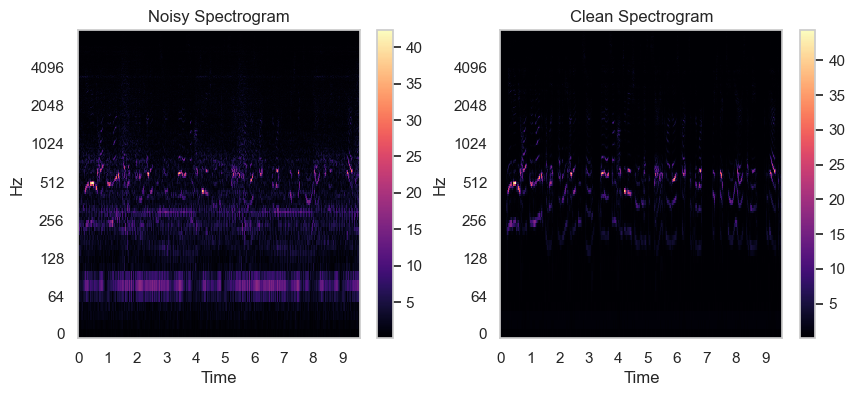

In [59]:
# Example to verify alignment of a few spectrogram pairs
for i in range(3):
    noisy_example = np.squeeze(train_noisy[i])  # Remove extra dimension
    clean_example = np.squeeze(train_clean[i])  # Remove extra dimension
    
    # Display or listen to both examples to confirm they align
    print(f"Example {i+1}:")
    plt.figure(figsize=(10, 4))
    
    # Plot noisy spectrogram
    plt.subplot(1, 2, 1)
    plt.title("Noisy Spectrogram")
    librosa.display.specshow(noisy_example, sr=16000, x_axis='time', y_axis='log')
    plt.colorbar()
    
    # Plot clean spectrogram
    plt.subplot(1, 2, 2)
    plt.title("Clean Spectrogram")
    librosa.display.specshow(clean_example, sr=16000, x_axis='time', y_axis='log')
    plt.colorbar()
    
    plt.show()
